In [1]:
import gym, recogym
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle as pkl
pd.options.mode.chained_assignment = None 
# from inspect import getsource
from recogym.evaluate_agent_sale import verify_agents_sale, plot_verify_agents_sale, plot_CR_CTR
from tqdm import tqdm

# env_1_sale_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_sale_args, Configuration
from recogym.envs.utils_sale import (share_states, share_sale, env_infos, count_sales_first_session, 
                                     get_beta_confidence_interval, share_user_with_sale, share_clicks_with_sale)
# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

# .reset() env before each episode (one episode per user).
env.reset()
done = False

env_1_sale_args['num_products'] = 10
num_products = env_1_sale_args['num_products']

# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym 
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

env_1_sale_args['number_of_flips'] = 5

## Build targets

In [2]:
## Clicks
from recogym.agents.sale_agent import ClickRewardProvider
Click_rewards = ClickRewardProvider()

## MDP
from recogym.agents.sale_agent import MDPRewardProvider
MDP_rewards = MDPRewardProvider()
MDP_rewards_all = MDPRewardProvider(clicks_only=False)
MDP_rewards_pureorganic = MDPRewardProvider(clicks_only=False, organic_only=True)

rewards = {'click':Click_rewards,
          'MDP':MDP_rewards,
          'MDP_all':MDP_rewards_all,
          'MDP_pureorganic':MDP_rewards_pureorganic}

## Build features

In [3]:
from recogym.agents.sale_agent import CountViewsClicksFeatureProvider, CountViewsFeatureProvider, ShareViewsClicksFeatureProvider, ShareViewsFeatureProvider
vc_feature = CountViewsClicksFeatureProvider(env.config)
v_feature = CountViewsFeatureProvider(env.config)
vc_share_feature = ShareViewsClicksFeatureProvider(env.config)
v_share_feature = ShareViewsFeatureProvider(env.config)

features = {'vc':vc_feature,
           'v':v_feature,
           'vc_share':vc_share_feature,
           'v_share':v_share_feature}

## Train baseline agents

In [22]:
# Choose number of users for training and AB test
# env_1_sale_args['num_users'] = 5000
env_1_sale_args['num_users'] = 15000
env_1_sale_args['num_users_AB'] = 5000
num_users = env_1_sale_args['num_users']
num_users_AB = env_1_sale_args['num_users_AB']

# Choose features
feature_name = 'v_share'
feature = features[feature_name]

In [26]:
from recogym.agents.sale_agent import build_train_data
from recogym.agents.sale_agent import SaleLikelihoodAgent, SaleProductLikelihoodAgent

agents={}
logs={}

############## Random agent
from recogym.agents import RandomAgent, random_args
random_agent = RandomAgent(Configuration(random_args))
name_agent = 'rand'
agents[name_agent] = random_agent
try:
    data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
except :
    data = deepcopy(env).generate_logs(num_users)
    pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
logs[name_agent] = data
    
############## Organic agent
from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
organic_counter_agent = OrganicUserEventCounterAgent(Configuration({**organic_user_count_args,
                                                                    **env_1_sale_args,
                                                                    'select_randomly': True}))
name_agent = 'organic'
agents[name_agent] = organic_counter_agent
try:
    data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
except :
    data = deepcopy(env).generate_logs(num_users,agent=organic_counter_agent)
    pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
logs[name_agent] = data
    
# ############## Likelihood click
# name_agent = "likclick"
# try :
#     data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
# except:
#     likelihood_logreg_click = SaleLikelihoodAgent(feature, Click_rewards)
#     likelihood_logreg_click.train(data)
#     agents[name_agent] = likelihood_logreg_click
#     data = deepcopy(env).generate_logs(num_users, agent=likelihood_logreg_click)
#     pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
# logs[name_agent] = data

# ############## Likelihood click kronecker
# name_agent = "likclickkron"
# try :
#     data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
# except:
#     likelihood_logreg_click = SaleLikelihoodAgent(feature, Click_rewards,kronecker_features=True)
#     likelihood_logreg_click.train(data)
#     agents[name_agent] = likelihood_logreg_click
#     data = deepcopy(env).generate_logs(num_users, agent=likelihood_logreg_click)
#     pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
# logs[name_agent] = data

## Random logging policy

In [16]:
def train_agents(name_logging,logs,feature_name,features, kronecker_features=False):
    info = {}
    save_agents = {}
    data = logs[name_logging]
    feature = features[feature_name]
    
    if kronecker_features==True:
        name_extension = 'kron'
    else:
        name_extension = ''
    
    # click agent
    likelihood_logreg_click = SaleLikelihoodAgent(feature, Click_rewards)
    likelihood_logreg_click.train(data)
    info[likelihood_logreg_click.info["Name"]] = likelihood_logreg_click.info
    save_agents["likelihood_logreg_click"+name_extension] = likelihood_logreg_click
    
    # No discount
    likelihood_saleclickprod = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_all], 
                                                    discounts=[0,0],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod.train(data)
    info[likelihood_saleclickprod.info["Name"]] = likelihood_saleclickprod.info
    save_agents["likelihood_saleclickprod"+name_extension] = likelihood_saleclickprod

    # non-specific discount, all observations
    likelihood_saleclickprod_discount_all = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_all,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod_discount_all.train(data)
    info[likelihood_saleclickprod_discount_all.info["Name"]] = likelihood_saleclickprod_discount_all.info
    save_agents["likelihood_saleclickprod_discount_all"+name_extension] = likelihood_saleclickprod_discount_all
    
    # non-specific discount, clicked observations
    likelihood_saleclickprod_discount = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod_discount.train(data)
    info[likelihood_saleclickprod_discount.info["Name"]] = likelihood_saleclickprod_discount.info
    save_agents["likelihood_saleclickprod_discount"+name_extension] = likelihood_saleclickprod_discount
    
    # Per product discount, all observations
    likelihood_saleclickprod_discount_spe_all = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_all,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod_discount_spe_all.train(data)
    info[likelihood_saleclickprod_discount_spe_all.info["Name"]] = likelihood_saleclickprod_discount_spe_all.info
    save_agents["likelihood_saleclickprod_discount_spe_all"+name_extension] = likelihood_saleclickprod_discount_spe_all
    
    # Per product discount, clicked observations
    likelihood_saleclickprod_discount_spe = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod_discount_spe.train(data)
    info[likelihood_saleclickprod_discount_spe.info["Name"]] = likelihood_saleclickprod_discount_spe.info
    save_agents["likelihood_saleclickprod_discount_spe"+name_extension] = likelihood_saleclickprod_discount_spe
    
    pkl.dump([info,save_agents],open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'wb'))
    return info, save_agents

## 15000 users in training and 5000 in A/B

In [ ]:
# res_dict={}
name_extension=''

In [ ]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
        **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [ ]:
name_logging = 'organic'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
        **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [ ]:
pkl.dump(res_dict,
         open("data/res_dict"+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+"_"+str(len(res_dict))+".pkl","wb"))

### 5000 users in training and AB test

In [17]:
# res_dict={}
name_extension=''

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [02:32<00:00, 32.89it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [03:19<00:00, 25.09it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [2:26:18<00:00,  1.76s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [2:47:10<00:00,  2.01s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:49:51<00:00,  2.76s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:27:51<00:00,  2.49s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████████████████████████

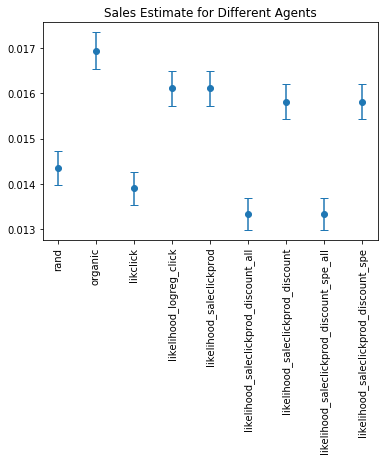

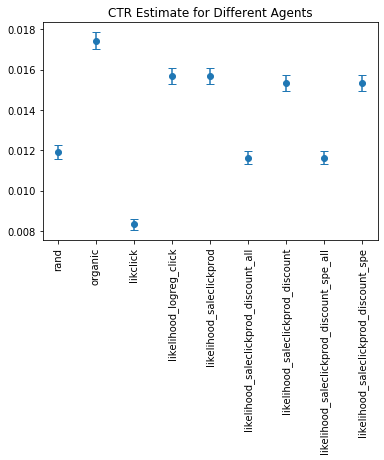

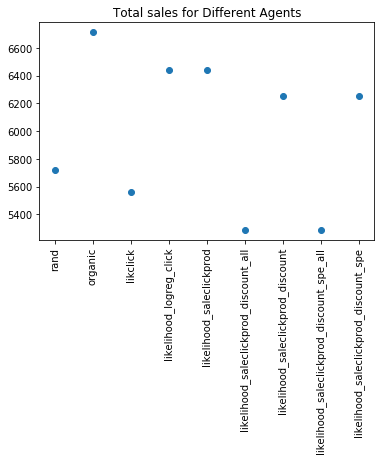

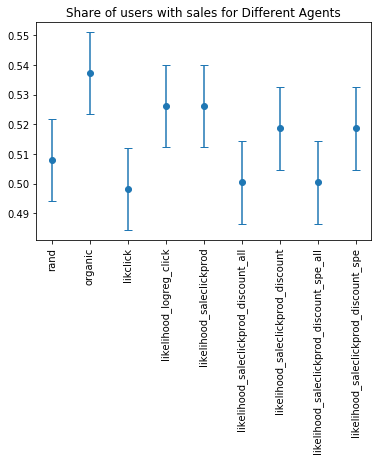

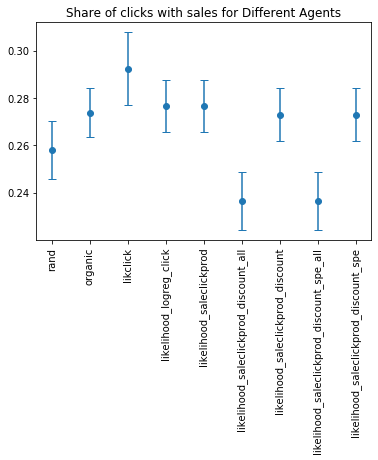

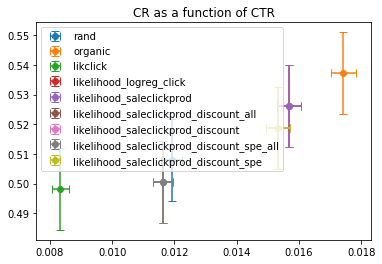

In [18]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [02:29<00:00, 33.41it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [03:16<00:00, 25.47it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [2:18:12<00:00,  1.66s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [2:18:41<00:00,  1.66s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:00:01<00:00,  2.16s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:29:16<00:00,  2.51s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████████████████████████

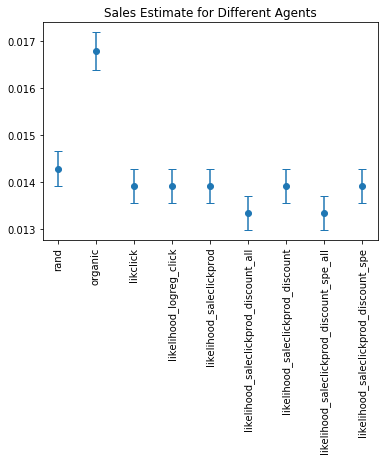

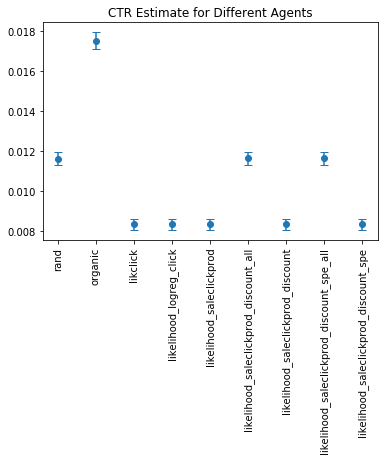

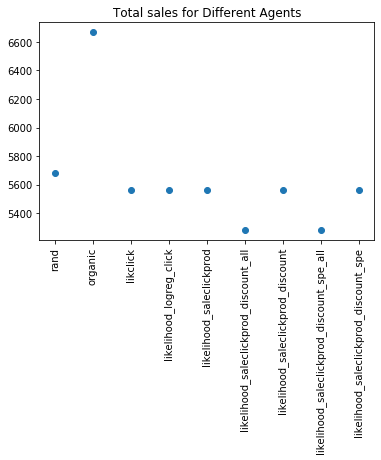

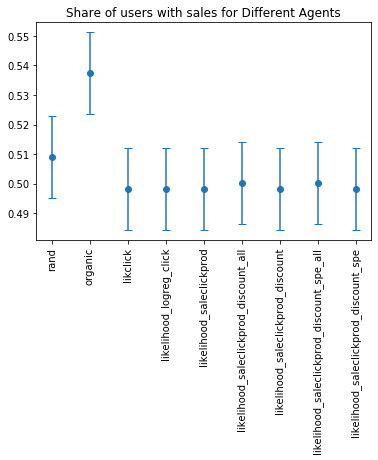

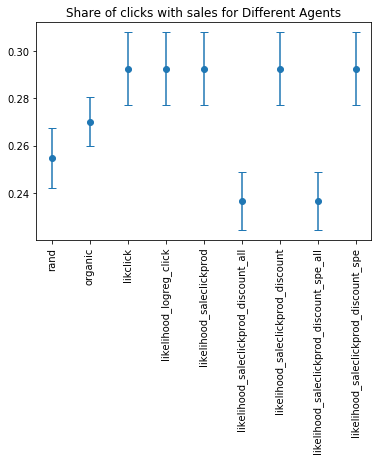

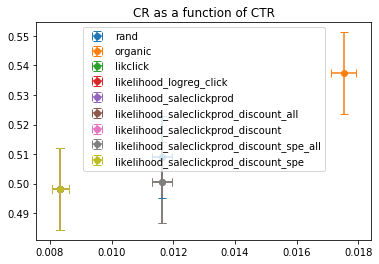

In [19]:
name_logging = 'organic'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [02:30<00:00, 33.13it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [03:15<00:00, 25.52it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [2:38:55<00:00,  1.91s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [2:16:27<00:00,  1.64s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [2:52:47<00:00,  2.07s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|████████████████████████████████████████████████████████████████████| 5000/5000 [15:48:33<00:00, 11.38s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████████████████████████

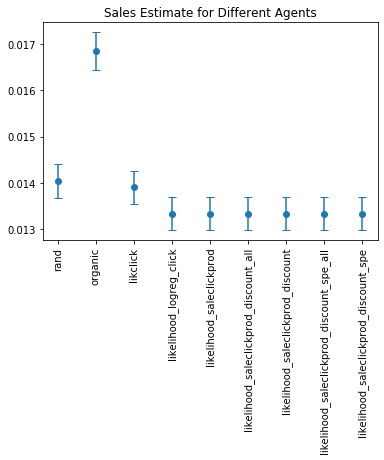

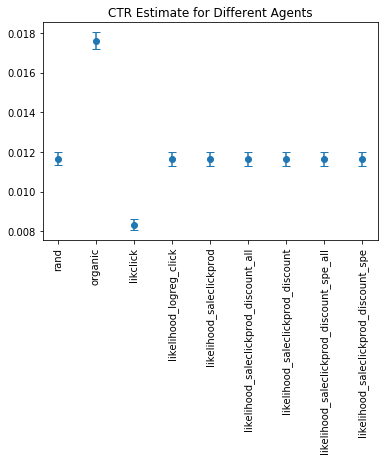

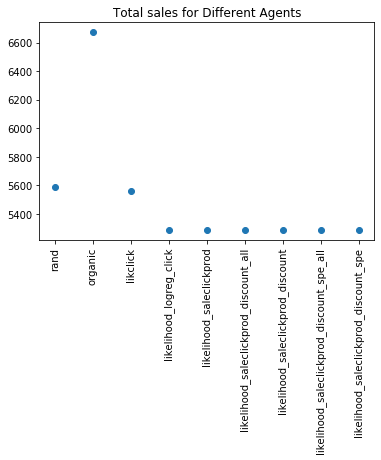

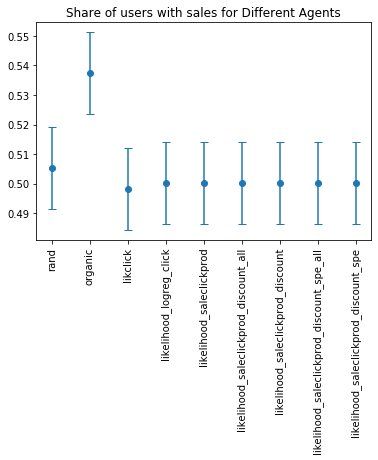

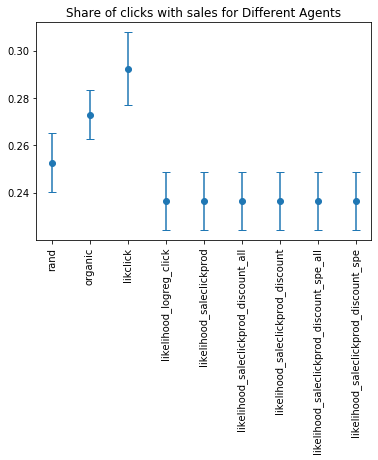

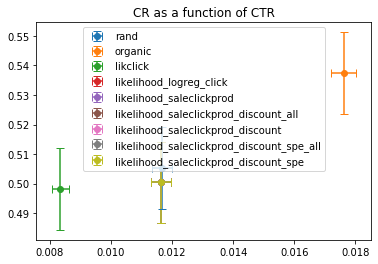

In [20]:
name_logging = 'likclickkron'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={**agents, **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [21]:
pkl.dump(res_dict,
         open("data/res_dict"+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+"_"+str(len(res_dict))+".pkl","wb"))

In [31]:
# res_dict['rand5000_5000_v_share']
# res_dict['organic5000_5000_v_share']
dico = res_dict['likclick5000_5000_v_share']
display(dico['sale rate'])
display(dico['CTR'])
display(dico['Tot sales'])
display(dico['Share user with sale'])
display(dico['reco'])

,Agent,0.025,0.500,0.975
0,rand,0.013670,0.014033,0.014401
1,organic,0.016446,0.016844,0.017248
2,likclick,0.013543,0.013903,0.014269
3,likelihood_logreg_click,0.012985,0.013339,0.013699
4,likelihood_saleclickprod,0.012985,0.013339,0.013699
5,likelihood_saleclickprod_discount_all,0.012985,0.013339,0.013699
6,likelihood_saleclickprod_discount,0.012985,0.013339,0.013699
7,likelihood_saleclickprod_discount_spe_all,0.012985,0.013339,0.013699
8,likelihood_saleclickprod_discount_spe,0.012985,0.013339,0.013699


,Agent,0.025,0.500,0.975
0,rand,0.011334,0.011664,0.012001
1,organic,0.017215,0.017621,0.018034
2,likclick,0.008055,0.008334,0.008619
3,likelihood_logreg_click,0.011306,0.011636,0.011973
4,likelihood_saleclickprod,0.011306,0.011636,0.011973
5,likelihood_saleclickprod_discount_all,0.011306,0.011636,0.011973
6,likelihood_saleclickprod_discount,0.011306,0.011636,0.011973
7,likelihood_saleclickprod_discount_spe_all,0.011306,0.011636,0.011973
8,likelihood_saleclickprod_discount_spe,0.011306,0.011636,0.011973


,Agent,TotSales
0,rand,5587
1,organic,6672
2,likclick,5559
3,likelihood_logreg_click,5288
4,likelihood_saleclickprod,5288
5,likelihood_saleclickprod_discount_all,5288
6,likelihood_saleclickprod_discount,5288
7,likelihood_saleclickprod_discount_spe_all,5288
8,likelihood_saleclickprod_discount_spe,5288


,Agent,0.025,0.500,0.975
0,rand,0.491542,0.505399,0.519249
1,organic,0.523555,0.537390,0.551186
2,likclick,0.484347,0.498200,0.512056
3,likelihood_logreg_click,0.486545,0.500400,0.514254
4,likelihood_saleclickprod,0.486545,0.500400,0.514254
5,likelihood_saleclickprod_discount_all,0.486545,0.500400,0.514254
6,likelihood_saleclickprod_discount,0.486545,0.500400,0.514254
7,likelihood_saleclickprod_discount_spe_all,0.486545,0.500400,0.514254
8,likelihood_saleclickprod_discount_spe,0.486545,0.500400,0.514254


{'rand':             t     u       z     v  a    c    r   ps ps-a
 300     164.0     2  bandit  <NA>  3  1.0  0.0  0.1   ()
 612     132.0     4  bandit  <NA>  9  1.0  1.0  0.1   ()
 657      30.0     5  bandit  <NA>  8  1.0  2.0  0.1   ()
 938     173.0     7  bandit  <NA>  9  1.0  0.0  0.1   ()
 985       7.0     9  bandit  <NA>  8  1.0  0.0  0.1   ()
 ...       ...   ...     ...   ... ..  ...  ...  ...  ...
 516797   70.0  4994  bandit  <NA>  2  1.0  0.0  0.1   ()
 517033  306.0  4994  bandit  <NA>  3  1.0  0.0  0.1   ()
 517055  328.0  4994  bandit  <NA>  0  1.0  0.0  0.1   ()
 517097   12.0  4995  bandit  <NA>  9  1.0  2.0  0.1   ()
 517219   64.0  4997  bandit  <NA>  9  1.0  0.0  0.1   ()
 
 [4644 rows x 9 columns],
 'organic':             t     u       z     v  a    c    r        ps ps-a
 120      15.0     1  bandit  <NA>  5  1.0  0.0  0.666667   ()
 293     164.0     2  bandit  <NA>  3  1.0  0.0  0.068182   ()
 446      80.0     3  bandit  <NA>  9  1.0  0.0  0.230769   ()
 567 

### 1000 users in training and AB test

In [7]:
# res_dict={}

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [30:32<00:00,  1.83s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [38:14<00:00,  2.29s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [44:12<00:00,  2.65s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [42:46<00:00,  2.57s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [43:57<00:00,  2.64s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [42:43<00:00,  2.56s/it]


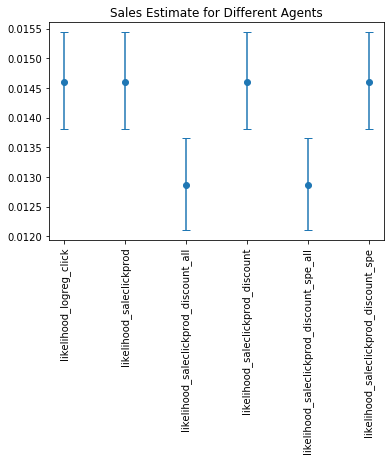

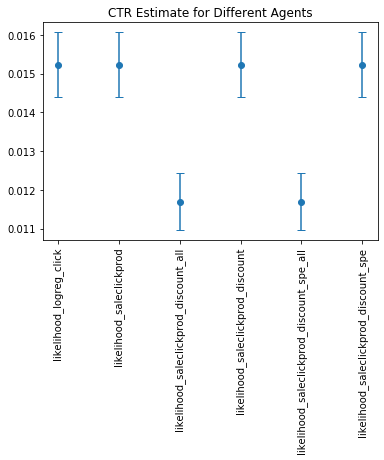

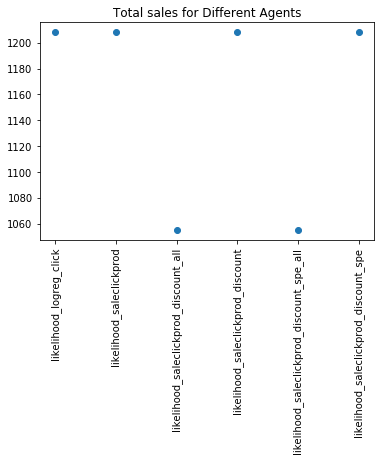

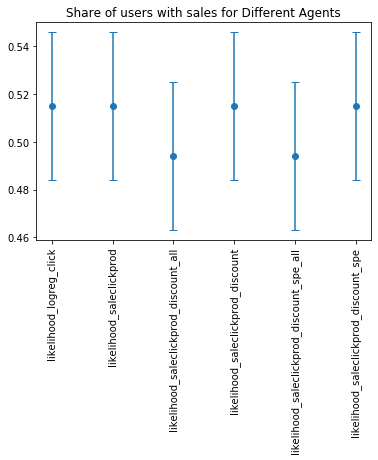

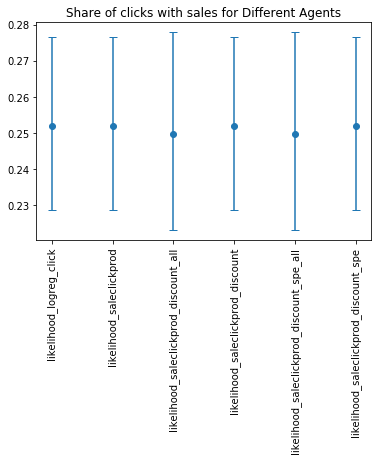

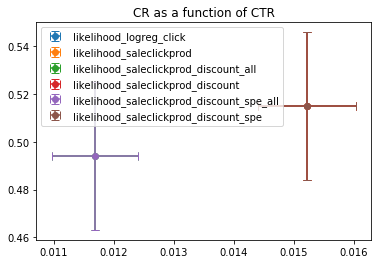

In [8]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [30:09<00:00,  1.81s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [37:41<00:00,  2.26s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [43:54<00:00,  2.63s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [45:16<00:00,  2.72s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [43:54<00:00,  2.63s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [45:30<00:00,  2.73s/it]


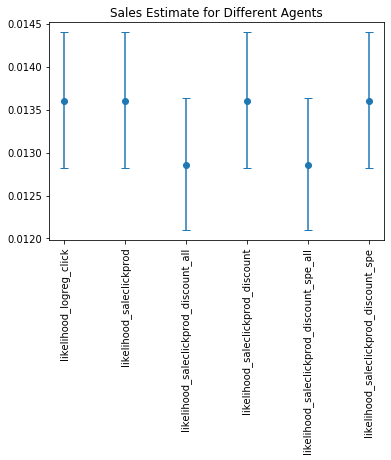

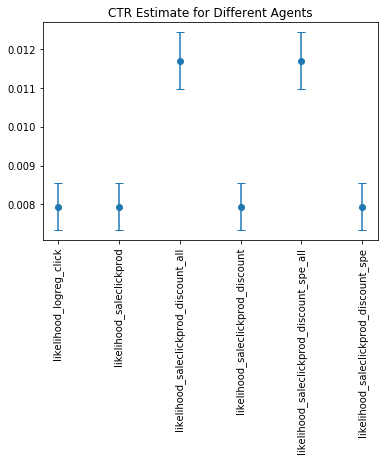

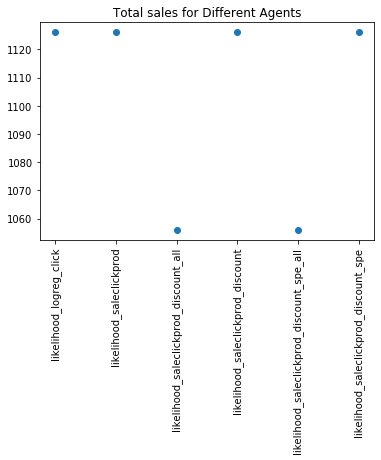

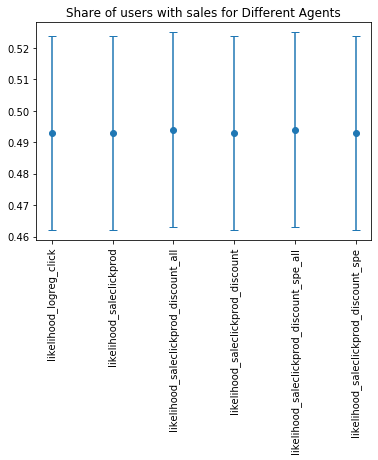

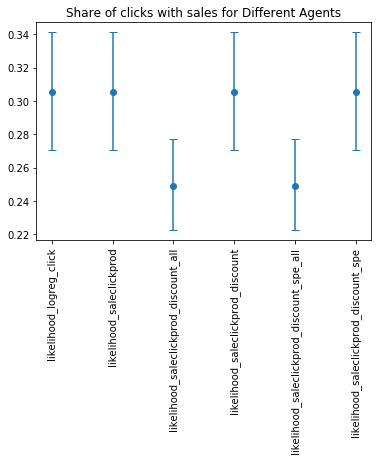

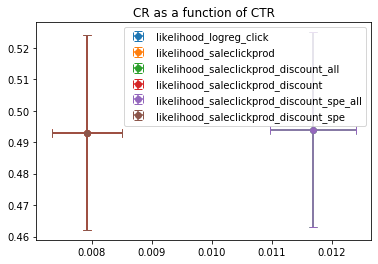

In [9]:
name_logging = 'organic'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [28:59<00:00,  1.74s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [36:21<00:00,  2.18s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [43:44<00:00,  2.62s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [43:51<00:00,  2.63s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [43:46<00:00,  2.63s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [44:02<00:00,  2.64s/it]


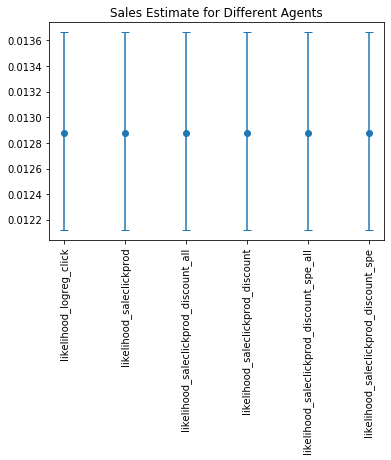

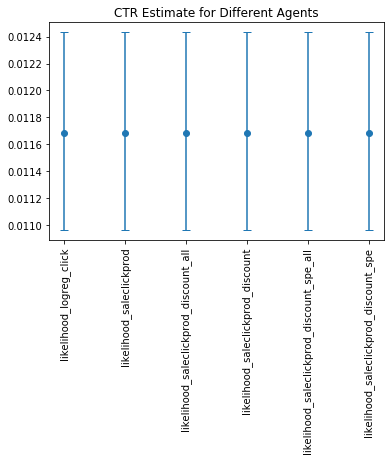

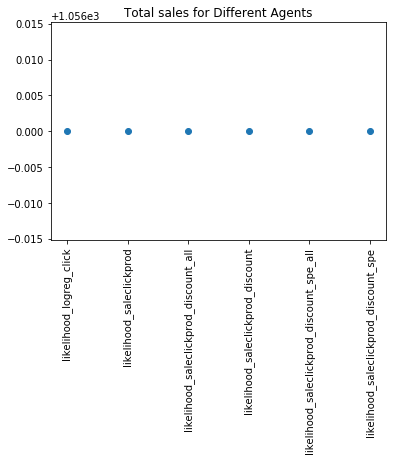

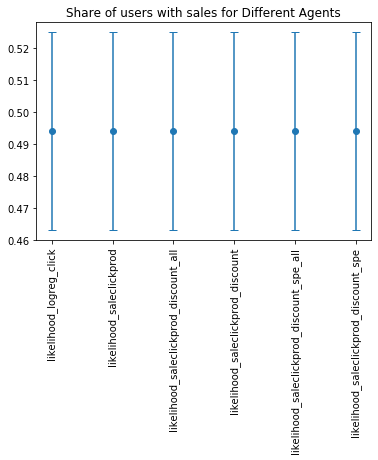

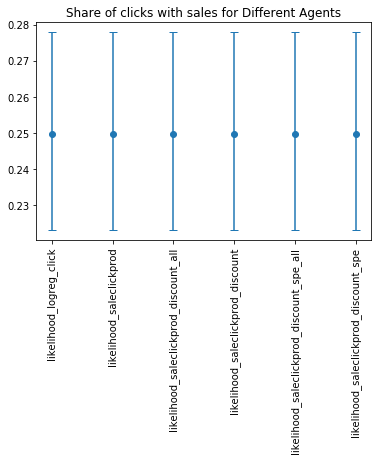

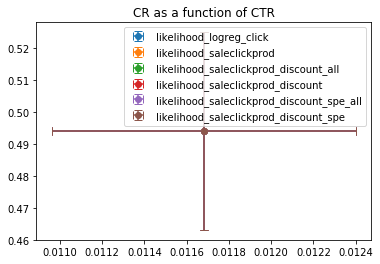

In [10]:
name_logging = 'likclickkron'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={**agents, **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [13]:
pkl.dump(res_dict,
         open("data/res_dict"+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+"_"+str(len(res_dict))+".pkl","wb"))

In [54]:
class SaleLikelihoodAgent(Agent):
    def __init__(self, feature_provider, reward_provider, kronecker_features = False, epsilon_greedy = False, epsilon = 0.3, seed=43):
        self.feature_provider = feature_provider
        self.reward_provider = reward_provider
        self.random_state = RandomState(seed)
        self.model = None
        self.epsilon_greedy = epsilon_greedy
        self.epsilon = epsilon
        self.logged_observation = {'t': [],'u': [], 'z': [],'v': [], 'a': [],
                                   'c': [],'r': [],'ps': [], 'ps-a': []}
        self.kronecker_features = kronecker_features
        
    @property
    def num_products(self):
        return self.feature_provider.config.num_products
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state"""
        features = np.zeros(len(user_state) + self.num_products)
        # just put a dummy variable
        features[:len(user_state)] = user_state
        features[int(len(user_state) + action)] = 1
        return features
    
    def _create_features_kronecker(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state"""
        features = np.zeros(len(user_state) * self.num_products)
        # perform kronecker product directly on the flattened version of the features matrix
        features[action*len(user_state):(action+1)*len(user_state)] = user_state
        return features
    
    def train(self, logs):
        user_states, actions, rewards, proba_actions, self.info = build_train_data(logs, 
                                                                        self.feature_provider, 
                                                                        self.reward_provider)
        
        rewards = (rewards > 0)*1
        # self.cr = sum(rewards)/len(rewards)
        
        actions_onehot = np.zeros((len(actions), self.num_products))
        actions_onehot[np.arange(len(actions)),actions] = 1
        
        if self.kronecker_features == False:
            features = np.hstack([
                user_states,
                actions_onehot
            ])
        else :
            features = np.array([self._create_features_kronecker(user_states[i],
                                                                    actions[i]) 
                                         for i in range(len(actions))])
        
        self.model = LogisticRegression(solver='lbfgs', max_iter=5000)
        self.model.fit(features, rewards)
        
    
    def _score_products(self, user_state):
        if self.kronecker_features == False:
            all_action_features = np.array([self._create_features(user_state,action)
                                            for action in range(self.num_products)])
        else :
            all_action_features = np.array([self._create_features_kronecker(user_state,action)
                                            for action in range(self.num_products)])
        print("shape",self.model.predict_proba(all_action_features).shape)
        print("all vector",self.model.predict_proba(all_action_features))
        return self.model.predict_proba(all_action_features)[:, 1]
    
    def observation_to_log(self,observation):
        data = self.logged_observation
        
        def _store_organic(observation):
            assert (observation is not None)
            assert (observation.sessions() is not None)
            for session in observation.sessions():
                data['t'].append(session['t'])
                data['u'].append(session['u'])
                data['z'].append('organic' if session['z']=='pageview' else 'sale') 
                data['v'].append(session['v'])
                data['a'].append(None)
                data['c'].append(None)
                data['r'].append(None) ##H
                data['ps'].append(None)
                data['ps-a'].append(None)

        def _store_clicks(observation):
            assert (observation is not None)
            assert (observation.click is not None)
            for session in observation.click:
                data['t'].append(session['t'])
                data['u'].append(session['u'])
                data['z'].append('bandit') 
                data['v'].append(None)
                data['a'].append(session['a'])
                data['c'].append(session['c'])
                data['r'].append(None) 
                data['ps'].append(None)
                data['ps-a'].append(None)

        _store_organic(observation)
        _store_clicks(observation)
        self.logged_observation = data
        
        # return as dataframe
        df = pd.DataFrame(data)
        df.sort_values('t')
        return df
        
    
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past history"""
        logged_observation = self.observation_to_log(observation)
        self.feature_provider.observe(logged_observation)      
        user_state = self.feature_provider.features()
        if (self.epsilon_greedy == True) & (np.random.rand() < self.epsilon) : 
            print("Explore")
            action = np.random.randint(self.num_products())
        else :
            print(self._score_products(user_state))
            action = np.argmax(self._score_products(user_state))
        
        ps = 1.0
        all_ps = np.zeros(self.num_products)
        all_ps[action] = 1.0        
        
        if done :
            self.reset()
        
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': ps,
                'ps-a': all_ps,
            }
        }

    def reset(self):
        self.feature_provider.reset() 
        self.logged_observation = {'t': [],'u': [], 'z': [],'v': [], 'a': [],
                                   'c': [],'r': [],'ps': [], 'ps-a': []}